# Pancreatic endocrine cell fate analysis

Notebooks for analyzing pancreatic endocrine cell fate decision

## Library imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ranksums

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "pancreatic_endocrine"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

In [6]:
VELOCITY_METHODS = ["regvelo", "velovi", "scvelo"]
N_STATES = [7, 10, 10]  # optimal states learned from `3_comparison_TSI`

## Data loading

### Using CellRank pipeline for fate mapping

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

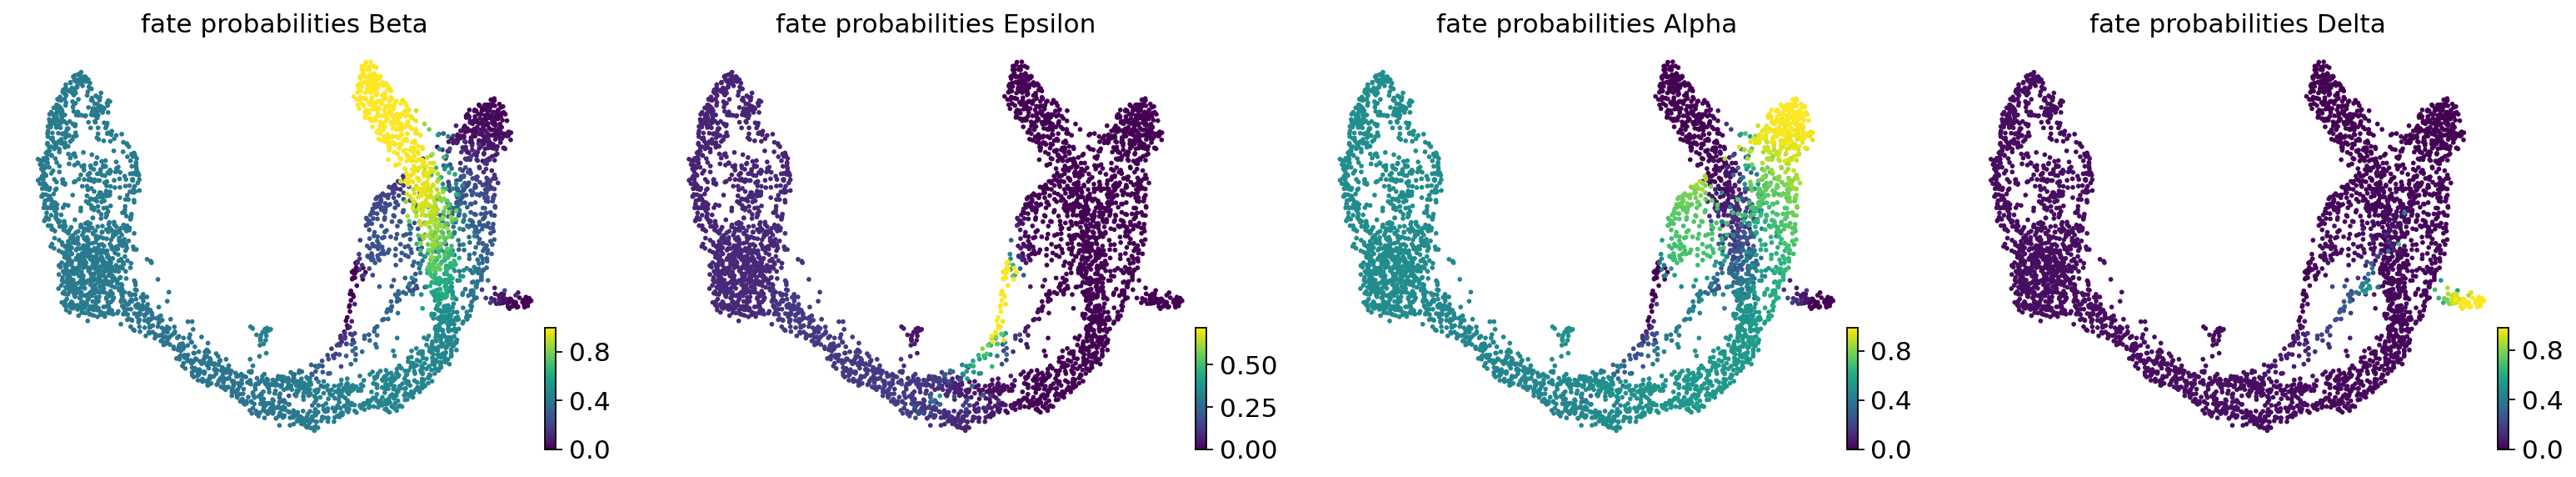

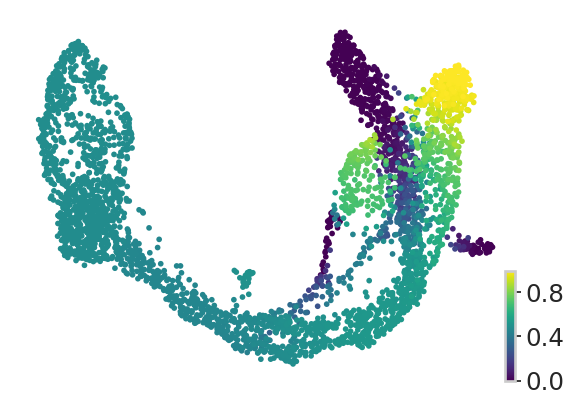

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

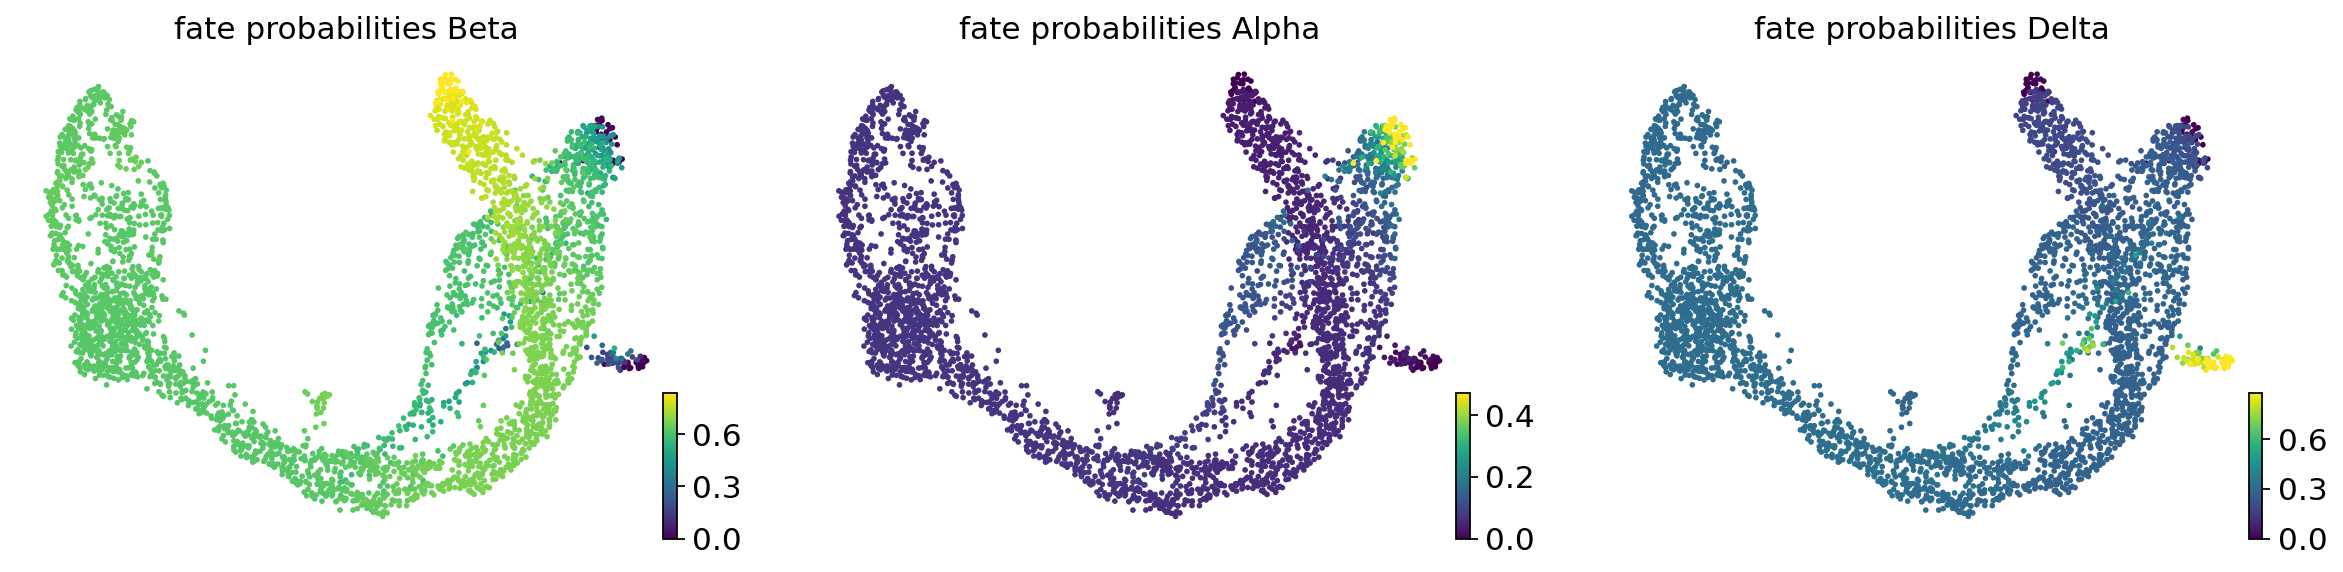

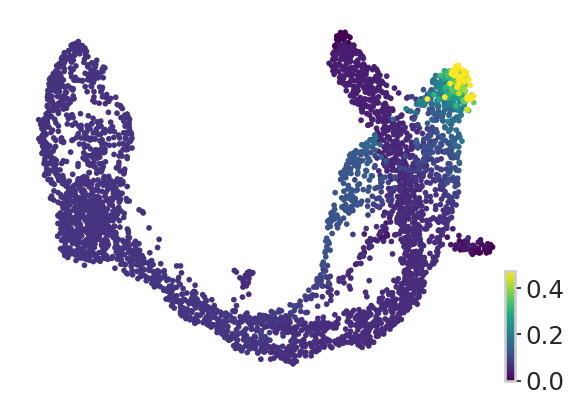

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


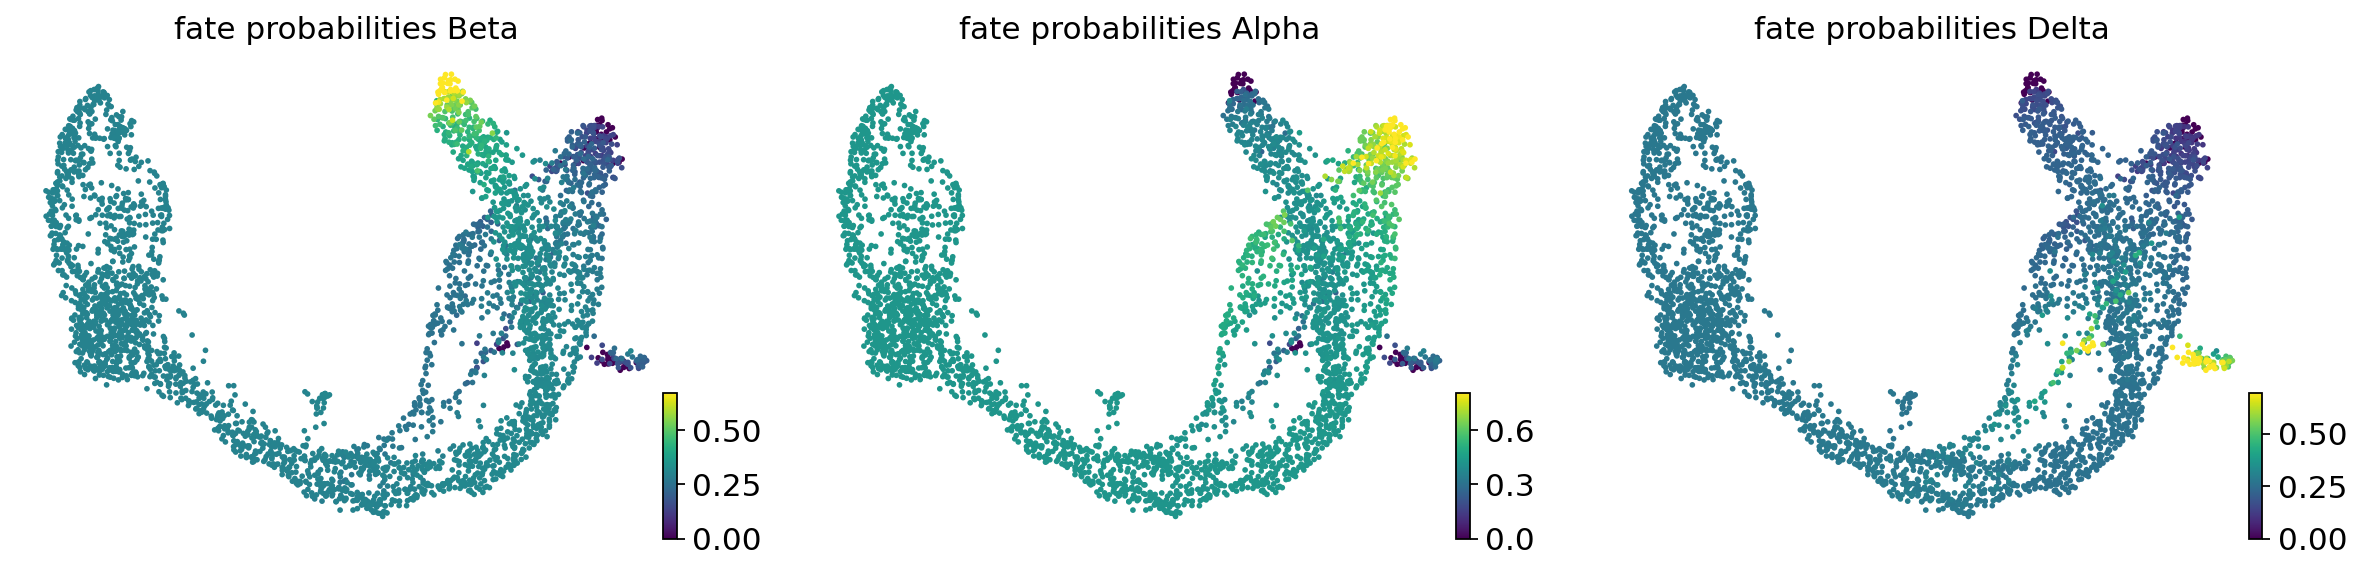

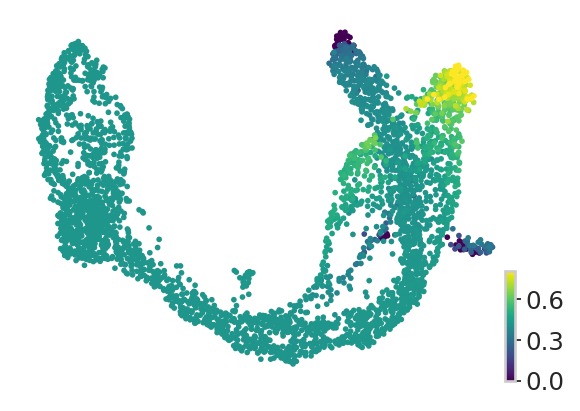

In [7]:
for _idx, (n_state, method) in enumerate(zip(N_STATES, VELOCITY_METHODS)):
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")
    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)

    estimator.compute_macrostates(n_states=n_state, cluster_key="clusters")
    estimator.set_terminal_states(
        list(set(estimator.macrostates.cat.categories.tolist()).intersection(TERMINAL_STATES))
    )
    estimator.compute_fate_probabilities(solver="direct")
    estimator.plot_fate_probabilities(same_plot=False)

    if method == "regvelo":
        fate_prob = estimator.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fate_prob.names.tolist()
        fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)

    with mplscience.style_context():
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.set_style(style="whitegrid")
        estimator.plot_fate_probabilities(states=["Alpha"], same_plot=False, title="", ax=ax)

        if SAVE_FIGURES:
            fig.savefig(
                FIG_DIR / DATASET / f"alpha_cell_{method}.svg", format="svg", transparent=True, bbox_inches="tight"
            )

        plt.show()

## Identify Epsilon's subpopulstions

In [8]:
adata.obs["Alpha"] = fate_prob.loc[:, "Alpha"]

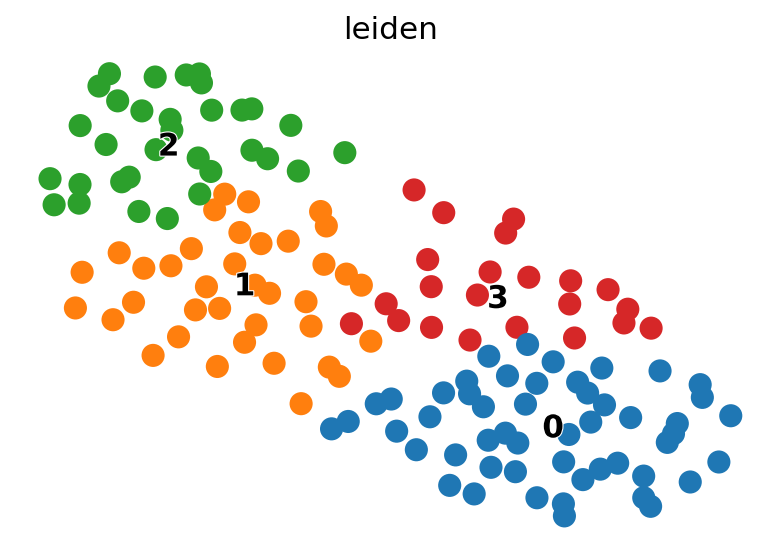

In [9]:
Epsilon = adata[adata.obs["clusters"] == "Epsilon"].copy()
## calculate pca and plot umap
sc.tl.pca(Epsilon)
sc.pp.neighbors(Epsilon)
sc.tl.leiden(Epsilon)
sc.tl.umap(Epsilon)
scv.pl.umap(Epsilon, color="leiden", legend_loc="on data")

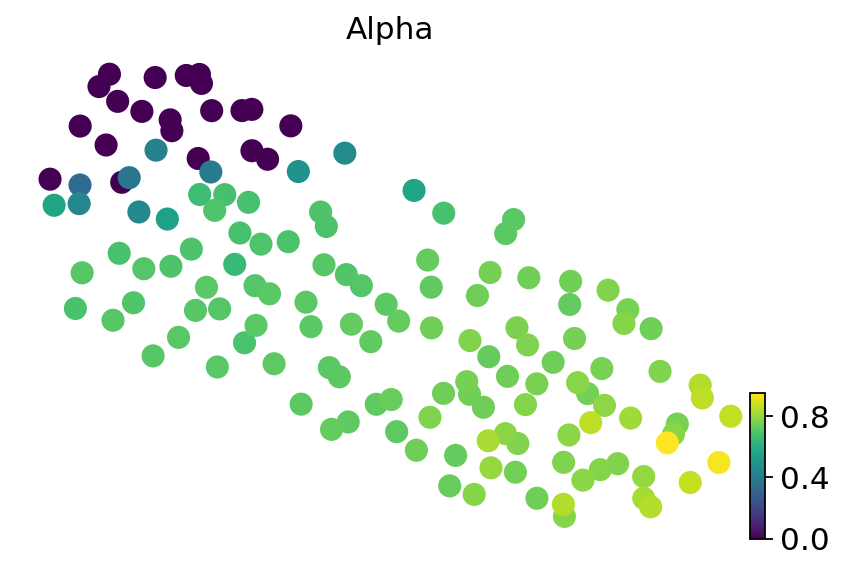

In [10]:
scv.pl.umap(Epsilon, color="Alpha")

## Identify differential expressed TF among two populations

In [12]:
## screening TF, identify the driver
TF_list = adata.var_names[adata.var["tf"]]
pval = []
for i in TF_list:
    x = np.array(Epsilon[Epsilon.obs["leiden"] != "2", i].X.todense()).flatten()
    y = np.array(Epsilon[Epsilon.obs["leiden"] == "2", i].X.todense()).flatten()
    _, res = ranksums(x, y, alternative="greater")
    pval.append(res)

In [13]:
res = pd.DataFrame({"TF": list(TF_list), "Pval": pval})
res = res.sort_values(by="Pval")
res

,TF,Pval
35,Irx1,0.001671
62,Pou6f2,0.003126
44,Meis2,0.011591
17,Fev,0.027347
36,Irx2,0.086176
...,...,...
1,Arx,0.998394
20,Foxa2,0.999690
21,Foxa3,0.999846
66,Rfx6,0.999997


## Visualize DEG

In [14]:
cell_states = np.array(Epsilon.obs["leiden"].copy())
cell_states[cell_states == "2"] = "State 1"
cell_states[cell_states != "State 1"] = "State 2"

In [15]:
Epsilon.obs["cell_states"] = list(cell_states)

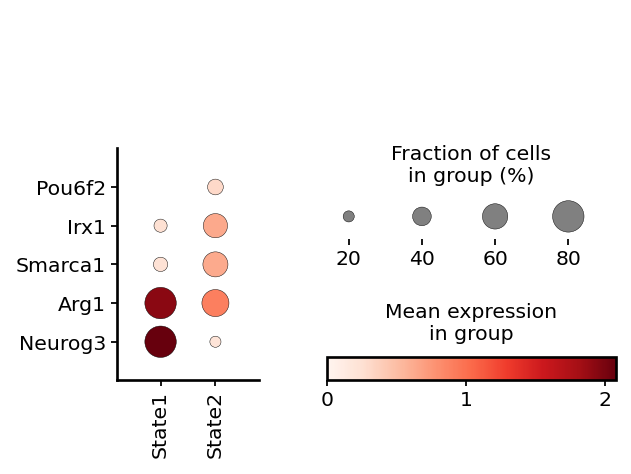

In [16]:
## Visualize gene expression dynamics
with mplscience.style_context():
    markers = ["Pou6f2", "Irx1", "Smarca1", "Arg1", "Hes6", "Neurog3"]
    fig, ax = plt.subplots(figsize=(4, 3))
    # sns.set_style(style="whitegrid")
    sc.pl.dotplot(Epsilon, markers, groupby="cell_states", swap_axes=True, dot_max=0.8, ax=ax)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "feature_marker_expression.svg", format="svg", transparent=True, bbox_inches="tight"
        )

    plt.show()